# RNA-seq Exploratory Data Analysis (GSE60424)

**Project Goal:** Explore RNA-seq count data from human T cells in resting vs activated states.  
We will perform exploratory data analysis (EDA) to understand sample structure, gene variability, and basic biological insights.

---


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
expr = pd.read_csv("GSE60424_GEOSubmit_FC1to11_normalized_counts.txt", sep="\t", 
                   header=0,
                   index_col=0)

In [3]:
expr

,lib221,lib222,lib223,lib224,lib225,lib226,lib227,lib228,lib229,lib230,...,lib346,lib347,lib348,lib349,lib350,lib351,lib352,lib353,lib354,lib355
genenames,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,1,0,1,1,1,0,0,0,2,1,...,1,0,1,0,0,0,1,1,0,0
ENSG00000000005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000000419,23,22,25,28,25,41,18,12,14,20,...,28,19,35,37,25,17,22,25,25,30
ENSG00000000457,11,11,14,17,11,32,9,24,19,16,...,18,13,15,26,5,23,17,15,14,14
ENSG00000000460,3,3,3,3,2,4,5,9,4,6,...,11,9,5,4,7,12,8,8,11,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000261837,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000261838,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000261839,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0


#### PCA Using CPM Normalization

In [4]:
# Normalize to counts per million to avoid bias from sequencing depth

cpm = expr.div(expr.sum(axis=0), axis=1) * 1e6
print(cpm)

                    lib221     lib222     lib223     lib224     lib225  \
genenames                                                                
ENSG00000000003   0.883776   0.000000   0.899917   1.076120   1.108167   
ENSG00000000005   0.000000   0.000000   0.000000   0.000000   0.000000   
ENSG00000000419  20.326856  21.531665  22.497917  30.131373  27.704177   
ENSG00000000457   9.721540  10.765832  12.598833  18.294048  12.189838   
ENSG00000000460   2.651329   2.936136   2.699750   3.228361   2.216334   
...                    ...        ...        ...        ...        ...   
ENSG00000261837   0.000000   0.000000   0.000000   0.000000   0.000000   
ENSG00000261838   0.000000   0.000000   0.000000   0.000000   0.000000   
ENSG00000261839   0.000000   0.000000   0.000000   0.000000   0.000000   
ENSG00000261840   0.883776   0.978712   0.899917   1.076120   1.108167   
ENSG00000261842   0.000000   0.000000   0.000000   0.000000   0.000000   

                    lib226     lib227

In [5]:
# Log transform to reduce skewness
log_cpm = np.log(cpm + 1)

# Transpose so samples are rows (for PCA)
X = log_cpm.T

# Run PCA
pca = PCA()
pca.fit(X)
pca_data = pca.transform(X)

# Get Principal components to choose the correct relevance by variance
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
print(per_var)

[49.7 13.3 11.4  7.1  4.9  1.3  1.   0.8  0.7  0.6  0.5  0.4  0.3  0.3
  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.1  0.1  0.1  0.1  0.1
  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0. ]


In [6]:
# First 4 PCs cumulative varaince
print(np.sum(per_var[0:4]))


81.5


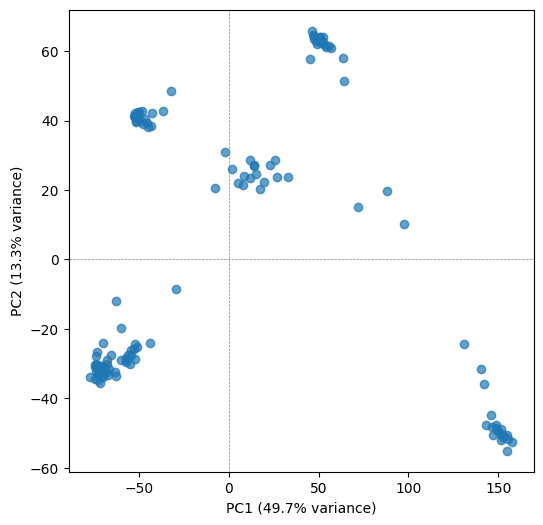

In [7]:
# Plot PC1 vs PC2
plt.figure(figsize=(6,6))
plt.scatter(pca_data[:,0], pca_data[:,1], alpha=0.7)
plt.xlabel(f"PC1 ({per_var[0]}% variance)")
plt.ylabel(f"PC2 ({per_var[1]}% variance)")
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.show()


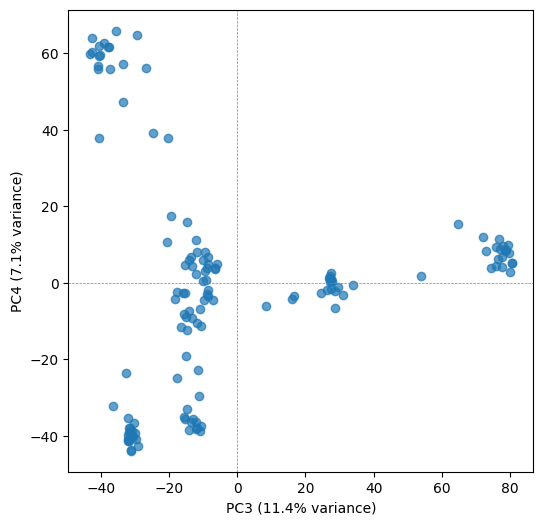

In [8]:
# Plot PC3 vs PC4
plt.figure(figsize=(6,6))
plt.scatter(pca_data[:,2], pca_data[:,3], alpha=0.7)
plt.xlabel(f"PC3 ({per_var[2]}% variance)")
plt.ylabel(f"PC4 ({per_var[3]}% variance)")
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.show()

#### PCA Using TPM Normalization

In [9]:
# Read GTF
gtf_file = "gencode.v49.chr_patch_hapl_scaff.basic.annotation.gtf"
gtf = pd.read_csv(gtf_file, sep="\t", comment="#", header=None,
        names=["chr", "source", "feature", "start", "end", "score", "strand", "frame", "attribute"]
)

# Keep exons only (to calculate gene length)
exons = gtf[gtf["feature"] == 'exon']

# Extract gene_id from the attribute column
exons['gene_id'] = exons['attribute'].str.extract('gene_id "([^"]+)"')

# Calculate exon length
exons['length'] = exons['end'] - exons['start'] + 1

# Sum exon lengths per gene
gene_lengths = exons.groupby('gene_id')['length'].sum()

# Convert to kilobases for TPM calculation
gene_lengths_kb = gene_lengths / 1000


/tmp/ipykernel_43890/2711331072.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exons['gene_id'] = exons['attribute'].str.extract('gene_id "([^"]+)"')
/tmp/ipykernel_43890/2711331072.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exons['length'] = exons['end'] - exons['start'] + 1


In [10]:
# Remove version suffix from gene_lengths_kb index
gene_lengths_kb.index = gene_lengths_kb.index.str.split('.').str[0]

# Align genes
common_genes = expr.index.intersection(gene_lengths_kb.index)

# Subset both data sets to only these genes
expr_aligned = expr.loc[common_genes]
gene_lengths_aligned = gene_lengths_kb.loc[common_genes]

In [11]:
# Step 1: RPK (reads per kilobase)
rpk = expr_aligned.div(gene_lengths_aligned, axis=0)

# Step 2: Scaling factor per sample (sum of RPKs)
scaling_factor = rpk.sum(axis=0)

# Step 3: TPM
tpm = rpk.div(scaling_factor, axis=1) * 1e6

# Step 4: log transform
log_tpm = np.log(tpm + 1)

print(log_tpm)

                   lib221    lib222    lib223    lib224    lib225    lib226  \
ENSG00000000003  0.252055  0.000000  0.256168  0.342551  0.340371  0.000000   
ENSG00000000005  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ENSG00000000419  2.794696  2.868052  2.890476  3.319426  3.203198  3.252454   
ENSG00000000457  1.096774  1.179944  1.276869  1.685062  1.340526  1.835368   
ENSG00000000460  0.291333  0.323712  0.295997  0.393387  0.276810  0.343156   
...                   ...       ...       ...       ...       ...       ...   
ENSG00000261837  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ENSG00000261838  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ENSG00000261839  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ENSG00000261840  1.233937  1.322222  1.246964  1.497339  1.491495  0.000000   
ENSG00000261842  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

                   lib227    lib228    lib229    li

Note: We lost some genes because of alignment with the GTF data.

In [12]:
print(log_tpm.shape)
print(log_cpm.shape)

(44142, 134)
(50045, 134)


In [13]:
# Transpose so samples are rows (for PCA)
X = log_tpm.T

# Run PCA
pca = PCA()
pca.fit(X)
pca_data = pca.transform(X)

# Get Principal components to choose the correct relevance by variance
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
print(per_var)

[38.4 12.3 10.4  8.6  5.3  1.6  1.4  1.3  0.8  0.7  0.6  0.6  0.5  0.4
  0.4  0.4  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.2  0.2  0.2
  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2
  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.1  0.1
  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0. ]


Note: the variance is spread across more genes with TPM normalization than with CPM normalization. This is probably due to the fact that with TPM, long genes no longer dominate, and we get a more balanced view of expression.

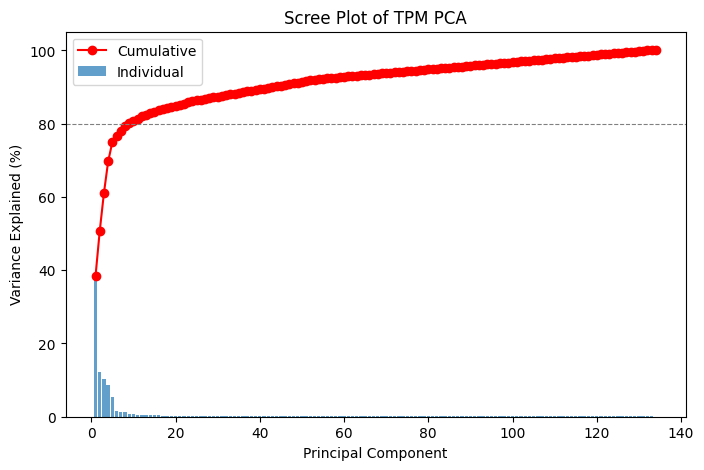

In [14]:
cumulative_var = np.cumsum(per_var)

# Scree plot
plt.figure(figsize=(8,5))
plt.bar(range(1, len(per_var) + 1), per_var, alpha=0.7, label='Individual')
plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, marker='o', color='red', label='Cumulative')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained (%)')
plt.title('Scree Plot of TPM PCA')
plt.axhline(80, color='gray', linestyle='--', linewidth=0.8)  # 80% reference line
plt.legend()
plt.show()

Contrast to CPM, now it seems we need more than 4 PCs to capture at least 80% of the variance.

#### Hierarchical Clustering

Genes with mean TPM >= 1: 14726 / 44142
Top 1000 genes:
                    lib221    lib222    lib223    lib224    lib225     lib226  \
ENSG00000163221  8.090319  8.425109  8.023511  7.771747  7.756186   8.520547   
ENSG00000143546  9.083100  9.037538  8.946544  8.590308  8.517053   9.761562   
ENSG00000163220  9.864285  9.801841  9.704545  9.226101  9.311230  10.475235   
ENSG00000163993  7.253482  7.305468  6.731911  7.840231  6.679596   8.018857   
ENSG00000105501  7.557934  7.591088  7.718066  7.466335  6.566874   8.809899   
...                   ...       ...       ...       ...       ...        ...   
ENSG00000162892  3.542401  3.791778  3.309081  3.859601  4.170122   0.626059   
ENSG00000136250  3.850646  3.868859  4.039317  4.291219  3.786281   4.066916   
ENSG00000257341  0.000000  0.000000  0.000000  0.000000  0.000000   0.000000   
ENSG00000237169  2.640337  2.754487  2.657369  0.000000  0.000000   3.596069   
ENSG00000230092  0.000000  0.000000  0.000000  0.000000  0.0000

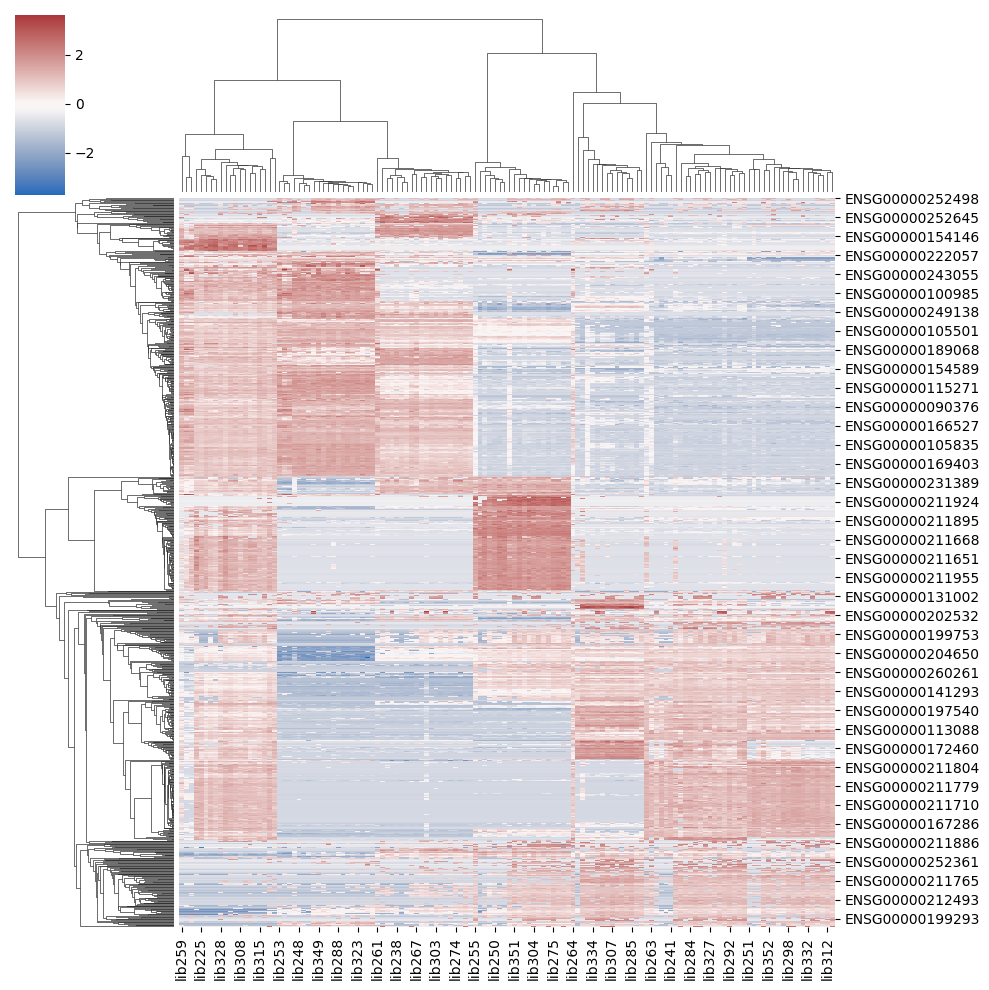

In [ ]:
# Filter out genes with TPM < 1
mean_tpm = tpm.mean(axis=1)
expr_mask = mean_tpm >= 1.0
print(f'Genes with mean TPM >= 1: {expr_mask.sum()} / {len(expr_mask)}')
filtered = log_tpm.loc[expr_mask]

gene_var = filtered.var(axis=1)

# Subset of top N genes
N = 1000
top_genes = gene_var.nlargest(N).index
subset = filtered.loc[top_genes]
print(f'Top {N} genes:\n', subset)

g = sns.clustermap(
    subset,
    metric='correlation',
    method='average',
    z_score=0,
    cmap='vlag',
    figsize=(10,10)
)


